In [1]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default

import numpy as np
from sklearn import tree
from matplotlib import pyplot as plt # for a good visualization of the trees
import time

from Solver import *
from User import *

In [2]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm
import clustering as cl
import decision_tree as dt

In [3]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 100

# Number of iteration stop criterion
it_max = 5




# The number of solutions that we will have in the solver after the first iteration
k_k = 15

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, starts = fm.initialize_solver(data, n, m, duration)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k, n, m, T_machine, optimalval, tps_max, it_max)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 2431000
Le max de list_obj est 3806460
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x000001DD6DC74B40>, <docplex.cp.solution.CpoSolveResult object at 0x000001DD68F7AB40>, <docplex.cp.solution.CpoSolveResult object at 0x000001DD758ABB40>], [<docplex.cp.solution.CpoSolveResult object at 0x000001DD74

In [4]:
####################################################################
#### Arbre de décision : RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################


###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]
it_max_exploration = 0.75*it_max
tps_max_exploration = 0.75*tps_max
criterion = (tps < tps_max_exploration) and (it < it_max_exploration) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # # --------- Compute decision trees
    
    clf, conditions = dt.my_decision_tree(n, m, list_layers)
    print("Conditions :", conditions)
     
    # solver.add_constraint(model, dt.my_decision_tree_predict([model.start_of(variables[i//m][i%m]) for i in range(n*m)], clf) == 0)         
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, T_machine, optimalval, tps_max_exploration, it_max_exploration)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max_exploration) and (it < it_max_exploration) 
    fm.stopCondition(it, it_max_exploration, tps, tps_max_exploration)


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !
Score: 1.0
Best score: 1.0 with parameters: {'max_depth': 10, 'min_samples_split': 5, 'splitter': 'best'}
Score: 1.0
Score: 0.5
Score: 0.5
Score: 0.5
Score: 0.5
Score: 1.0
Score: 1.0
Score: 0.5
Score: 0.5
Score: 0.5
Score: 0.5
Conditions : [['16 <= 647.0', 1], ['16 > 647.0', 0]]

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 6309
Objective function : [2431000, 2328396]
Model solved !

Classing solutions...
Le min de list_obj est 2328396
Le max de list_obj est 3806460
Solutions classed !

Creating preferences...
Preferences created !
Il y a 25 solution(s)
Objective function global : [2431000, 2328396]

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences betw


--------Implementation of the decision tree...---------
7


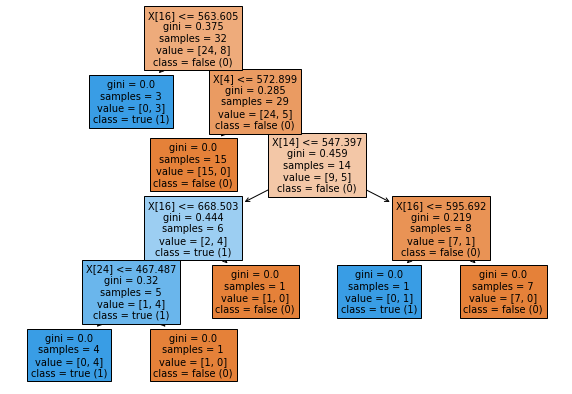

In [8]:
# Implementation of the decision tree

print("\n--------Implementation of the decision tree...---------")
print(len(conditions))
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf, 
                    class_names= ("false (0)", "true (1)" ), 
                    filled=True)
# X = Training set

# Y = classes associated to the training set